# 1 - LDAModel Implementation & Finetuning Using Titles Only

In this notebook, we implemented the Latent Dirichlet Allocation (LDA) model using only the titles from our dataset. The dataset was loaded from the previously prepared and preprocessed dataset. However, as a sanity check, we performed an additional validation step before inputting the data into the model. Throughout the entire process, energy consumption was monitored using the CodeCarbon library to measure computational resource usage.

The workflow was divided into five distinct stages:
1.	**Preliminary Experiment:** Initial LDA modeling using default hyperparameters (`num_topics=4, alpha='symmetric', eta=None`) on titles only.
2. **Coherence Scores Evaluation:** Using coherence scores to evaluate the preliminary experiment results and for fine-tuning evaluation metrics.
3.	**Hyperparameter Fine-tuning:** Optimization of hyperparameters (`num_topics, alpha, eta`) to maximize model coherence.
4.	**Final Model Training:** Application of the optimized hyperparameters to train the final LDA model specifically on titles.
5. **Results Preservation:** Saving the final results and the best-performing LDA model, which will subsequently be applied to abstracts and the combined dataset (titles and abstracts).


In [ ]:
# carbon tracker initialization
from codecarbon import OfflineEmissionsTracker
tracker = OfflineEmissionsTracker(country_iso_code="IRL", project_name="LDA", measure_power_secs=60)
tracker.start()

[codecarbon INFO @ 17:10:23] offline tracker init
[codecarbon ERROR @ 17:10:23] Does not support country with ISO code IE Exception occurred 'IE'
[codecarbon INFO @ 17:10:23] [setup] RAM Tracking...
[codecarbon INFO @ 17:10:23] [setup] CPU Tracking...
[codecarbon WARNING @ 17:10:23] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 17:10:23] We saw that you have a Apple M2 but we don't know it. Please contact us.
[codecarbon INFO @ 17:10:23] CPU Model on constant consumption mode: Apple M2
[codecarbon INFO @ 17:10:23] [setup] GPU Tracking...
[codecarbon INFO @ 17:10:23] No GPU found.
[codecarbon INFO @ 17:10:23] >>> Tracker's metadata:
[codecarbon INFO @ 17:10:23]   Platform system: macOS-15.4-arm64-arm-64bit
[codecarbon INFO @ 17:10:23]   Python version: 3.9.18
[codecarbon INFO @ 17:10:23]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 17:10:23]   Available RAM : 8.0

## Intsallations

In [ ]:
# This script is intended to be run in a Jupyter notebook environment
# such as Google Colab or JupyterLab.

# install dependencies
!pip install -r requirements.txt
# clear output
from IPython.display import clear_output
clear_output()

In [ ]:
import re
import string
import gdown
import warnings
from collections import Counter, OrderedDict
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import scipy as sp
import seaborn as sns
from IPython.display import clear_output
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm

import gensim
from gensim import models, corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import gensim.models.phrases as gen

# Suppress warnings
warnings.filterwarnings('ignore')

# Initialize lemmatizer
lmtzr = WordNetLemmatizer()


## Step 1 - Data Loading
Load dataset.

In [ ]:
# download the dataset using gdown
file_id = "1eZpccbF__INfFEYernG2EGPXhhTGOme1"
output_name = "cleaned_dataset.csv"

url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output_name, quiet=False)

In [ ]:
# load the dataset
df = pd.read_csv("cleaned_dataset.csv")

In [5]:
display(df.head(10))

,processed_title,processed_abstract,processed_title_and_abstract
0,population health strategy support hospital in...,country affect number people infect dead first...,population health strategy support hospital in...
1,gis jungle experiential environmental educatio...,travel course build hempel legacy environmenta...,gis jungle experiential environmental educatio...
2,impact american attitude study twitter,past research study social determinant attitud...,impact american attitude study twitter past re...
3,paxlovidtm information guidance member,american society ae official statement provide...,paxlovidtm information guidance member america...
4,upper respiratory tract infection sport immune...,simple summary review clarify relationship hea...,upper respiratory tract infection sport immune...
5,assess epidemic potential viruse,many new emerge virus zoonotic zoonotic origin...,assess epidemic potential viruse many new emer...
6,race get ready,coronavirus spread country nation fully prepar...,race get ready coronavirus spread country nati...
7,identification novel protein encode latency re...,latency relate lr encode abundantly express al...,identification novel protein encode latency re...
8,workbench probe lipidomic landscape,target lipidomic enable robust quantification ...,workbench probe lipidomic landscape target lip...
9,informal caregiver support need burden survey ...,demand informal care exist worldwide present i...,informal caregiver support need burden survey ...


Sanity check

In [7]:
# Count null values in processed_abstract column
null_count = df['processed_title'].isna().sum()
print(f"Number of null values in processed_title column: {null_count}")

# You can also check the percentage of null values
percentage = (null_count / len(df)) * 100
print(f"Percentage of null values: {percentage:.2f}%")

# Check null values in all columns
print("\nNull values in all columns:")
print(df.isna().sum())

Number of null values in processed_title column: 255
Percentage of null values: 0.26%

Null values in all columns:
processed_title                 255
processed_abstract               67
processed_title_and_abstract      5
dtype: int64


In [ ]:
# final cleanup
df['processed_abstract'] = df['processed_abstract'].fillna('')
df['processed_title'] = df['processed_title'].fillna('')
df['processed_title_and_abstract'] = df['processed_title_and_abstract'].fillna('')

In [9]:
len(df)

100000

## Step 2 - Preliminary Experiment

### Creating Vocabulary Bag-of-Words

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/sophie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[codecarbon INFO @ 17:11:23] Energy consumed for RAM : 0.000050 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:11:23] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:11:23] 0.000758 kWh of electricity used since the beginning.


In [ ]:
# Tokenize the processed_abstract strings into lists of words
df['processed_title'] = df['processed_title'].apply(lambda x: x.split() if isinstance(x, str) and x else [])

# Now create docs
docs = df['processed_title'].tolist()


[codecarbon INFO @ 17:12:23] Energy consumed for RAM : 0.000100 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:12:23] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:12:23] 0.001517 kWh of electricity used since the beginning.


In [11]:
 # Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents. Could change to 13%
dictionary.filter_extremes(no_below=20, no_above=0.1) # 10 => 20, 0.2 => 0.1
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 37866
Number of unique words after removing rare and common words: 4253


In [12]:
#creating a bag-of-words
len_of_dict = len(dictionary)
corpus = [dictionary.doc2bow(doc) for doc in docs]

bow_doc = corpus[len_of_dict]

print(f"bow_doc: {len(bow_doc)}")


bow_doc: 2


In [13]:
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0],
                                                     dictionary[bow_doc[i][0]],
                                                     bow_doc[i][1]))

Word 2 ("health") appears 1 time.
Word 669 ("vulnerability") appears 1 time.


### Creating LDA Model

In [14]:
#creating LDA Model
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [15]:
# Build LDA model
num_topics = 4
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics,
                                   random_state=100,
                                   chunksize=500,
                                   passes=20,
                                   alpha='symmetric',  # or a specific float value
                                   eta=None,  # or a specific float value
                                   per_word_topics=True)

[codecarbon INFO @ 17:13:23] Energy consumed for RAM : 0.000150 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:13:23] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:13:23] 0.002275 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:14:23] Energy consumed for RAM : 0.000200 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:14:23] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:14:23] 0.003034 kWh of electricity used since the beginning.


In [16]:
#viewing results
topics = get_lda_topics(lda_model, num_topics)
print(topics.T)

                  0      1         2           3            4        5  \
Topic # 01      sar  cov-2     virus        cell            -     base   
Topic # 02   health   care     study      impact            -  control   
Topic # 03   review   case  analysis  systematic       report     meta   
Topic # 04  disease  study  clinical   infection  coronavirus        -   

                      6        7        8          9  
Topic # 01    infection    human    model  detection  
Topic # 02       social     base  student      cross  
Topic # 03       global  surgery   effect      woman  
Topic # 04  respiratory    acute    child    outcome  


In [17]:
#enabling visualization
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [18]:
#visualizing using Gensim
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

#optional save
#pyLDAvis.save_html(vis, 'lda.html')

The above is the visual representation of the topic modelling and the below is the raw representation and we can specify #words with highest probability to display in each topic.

In [19]:
#saving model and specifying how many top words you want
lda_model.save('model4.gensim')
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.035*"sar" + 0.017*"cov-2" + 0.014*"virus" + 0.014*"cell" + 0.013*"-" + 0.012*"base" + 0.010*"infection" + 0.010*"human" + 0.010*"model" + 0.009*"detection"')
(1, '0.026*"health" + 0.019*"care" + 0.017*"study" + 0.013*"impact" + 0.011*"-" + 0.010*"control" + 0.010*"social" + 0.009*"base" + 0.008*"student" + 0.008*"cross"')
(2, '0.041*"review" + 0.023*"case" + 0.019*"analysis" + 0.018*"systematic" + 0.016*"report" + 0.010*"meta" + 0.009*"global" + 0.008*"surgery" + 0.008*"effect" + 0.008*"woman"')
(3, '0.030*"disease" + 0.028*"study" + 0.020*"clinical" + 0.018*"infection" + 0.018*"coronavirus" + 0.015*"-" + 0.013*"respiratory" + 0.012*"acute" + 0.012*"child" + 0.011*"outcome"')


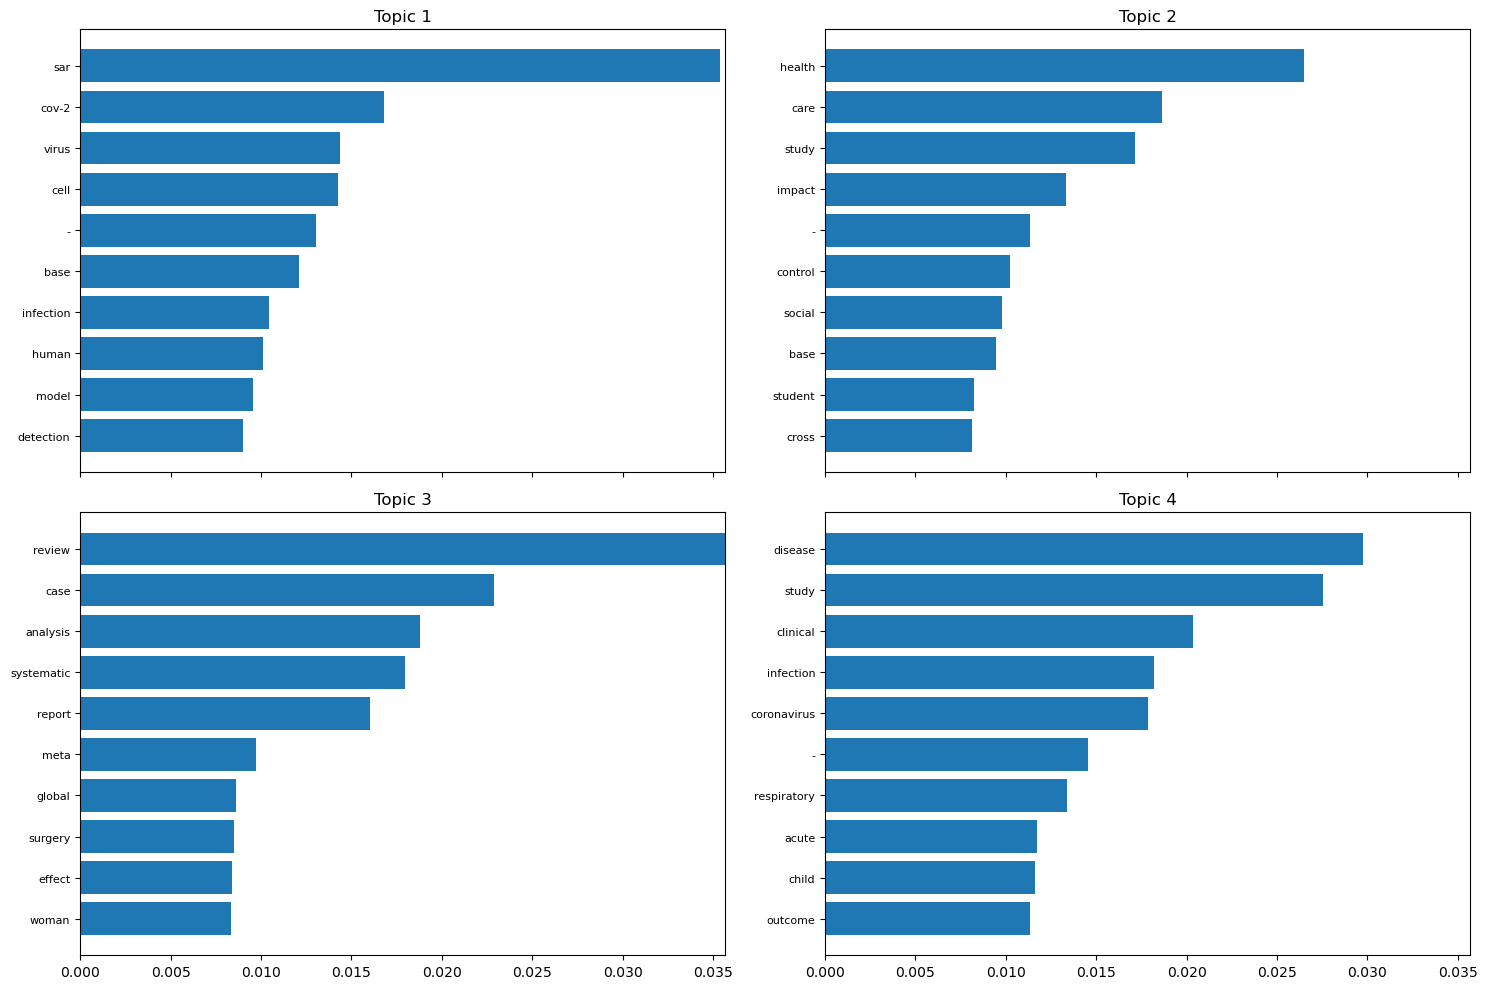

[codecarbon INFO @ 17:15:23] Energy consumed for RAM : 0.000250 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:15:23] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:15:23] 0.003792 kWh of electricity used since the beginning.


In [ ]:
# visulization topic words
def plot_top_words(lda_model, no_top_words):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, ax in enumerate(axes):
        top_words = lda_model.show_topic(topic_idx, no_top_words)
        x = [word for word, _ in top_words]
        y = [weight for _, weight in top_words]
        
        ax.barh(x, y)
        ax.set_title(f'Topic {topic_idx + 1}')
        ax.invert_yaxis()
        ax.tick_params(axis='y', labelsize=8)
        ax.set_xlim(0, max(y) * 1.2)
    
    plt.tight_layout()
    plt.show()

# Plotting the topics
no_top_words = 10
plot_top_words(lda_model, no_top_words)


## Step 3 - Evaluation - Coherence Scores

### What is coherence?

A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

**Topic Coherence:**
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.



### Measures of Coherence ##
1.  C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
2.  C_p is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
3.  C_uci measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
4.  C_umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
5.  C_npmi is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
6.  C_a is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

Gensim support all except 2 and 6, the rest were tested.


### Compute Coherence Scores

When evaluating an LDA model and have both available, it's generally recommended to use texts for coherence measures like 'c_v', 'c_uci', and 'c_npmi', while 'u_mass' coherence works with the corpus parameter.[(Topic coherence pipeline)](https://radimrehurek.com/gensim/models/coherencemodel.html)

In [21]:
coherences = ['c_v', 'u_mass', 'c_uci', 'c_npmi']
for coherence in coherences:
    if coherence == 'u_mass':
        cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence=coherence)
    else:
        cm = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence=coherence)
    print(f'Coherence Score {coherence}: {cm.get_coherence()}\n')


Coherence Score c_v: 0.428356194216996

Coherence Score u_mass: -3.725382839179933

Coherence Score c_uci: 0.1587942622910403

Coherence Score c_npmi: 0.04483065165446531



### Understanding Coherence Scores
Coherence scores typically range from 0 to 1, with higher values indicating better topic coherence. However, some measures like UMass coherence can have negative values, where values closer to zero are better.

The most common coherence measures include:

- **C_v coherence:** Based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure using normalized pointwise mutual information (NPMI) and the cosine similarity. Values typically range from 0 to 1, with higher scores indicating more coherent topics.

- **C_uci coherence:** Uses pointwise mutual information (PMI) on word pairs from the topic. Higher values indicate better coherence.

- **C_npmi coherence:** Similar to C_uci but uses normalized PMI. Range is typically between -1 and 1, with values closer to 1 being better.

- **U_mass coherence:** Based on document co-occurrence counts and a sliding window. Values are typically negative, with scores closer to zero indicating better coherence.

## Step 4 - Hyperparameter Finetuning - Bayesian optimization
Bayesian optimization would likely be better for our LDA task for several reasons:

- Efficiency: LDA training can be computationally expensive, especially with large corpora like CORD-19. Bayesian optimization requires fewer evaluations to find good hyperparameters.

- Parameter Sensitivity: LDA's performance can be sensitive to hyperparameters like alpha and eta. Bayesian optimization's adaptive nature helps navigate this complex parameter space more effectively.

- Continuous Parameters: Alpha and eta are continuous parameters that benefit from Bayesian optimization's ability to explore continuous spaces efficiently.

- Time Constraints: If you're working with time constraints, Bayesian optimization will likely find good hyperparameters faster than grid search.

**Reference:** 
1. [Hyperparameter Tuning: Grid Search, Random Search, and Bayesian Optimization](https://keylabs.ai/blog/hyperparameter-tuning-grid-search-random-search-and-bayesian-optimization/)
2. [Topic Modeling - LDA](https://ethen8181.github.io/machine-learning/clustering/topic_model/LDA.html)

Iteration No: 1 started. Evaluating function at random point.


[codecarbon INFO @ 17:17:23] Energy consumed for RAM : 0.000350 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:17:23] Energy consumed for all CPUs : 0.004959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:17:23] 0.005309 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:18:23] Energy consumed for RAM : 0.000400 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:18:23] Energy consumed for all CPUs : 0.005667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:18:23] 0.006067 kWh of electricity used since the beginning.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 83.9183
Function value obtained: -0.3331
Current minimum: -0.3331
Iteration No: 2 started. Evaluating function at random point.


[codecarbon INFO @ 17:19:23] Energy consumed for RAM : 0.000450 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:19:23] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:23] 0.006825 kWh of electricity used since the beginning.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 79.7455
Function value obtained: -0.3138
Current minimum: -0.3331
Iteration No: 3 started. Evaluating function at random point.


[codecarbon INFO @ 17:20:23] Energy consumed for RAM : 0.000500 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:20:23] Energy consumed for all CPUs : 0.007084 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:20:23] 0.007584 kWh of electricity used since the beginning.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 79.2657
Function value obtained: -0.3566
Current minimum: -0.3566
Iteration No: 4 started. Evaluating function at random point.


[codecarbon INFO @ 17:21:23] Energy consumed for RAM : 0.000550 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:21:23] Energy consumed for all CPUs : 0.007792 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:21:23] 0.008342 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:22:23] Energy consumed for RAM : 0.000600 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:22:23] Energy consumed for all CPUs : 0.008500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:22:23] 0.009100 kWh of electricity used since the beginning.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 86.8951
Function value obtained: -0.3312
Current minimum: -0.3566
Iteration No: 5 started. Evaluating function at random point.


[codecarbon INFO @ 17:23:23] Energy consumed for RAM : 0.000650 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:23:23] Energy consumed for all CPUs : 0.009209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:23:23] 0.009859 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:24:23] Energy consumed for RAM : 0.000700 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:24:23] Energy consumed for all CPUs : 0.009917 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:24:23] 0.010617 kWh of electricity used since the beginning.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 103.3079
Function value obtained: -0.3926
Current minimum: -0.3926
Iteration No: 6 started. Evaluating function at random point.


[codecarbon INFO @ 17:25:23] Energy consumed for RAM : 0.000750 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:25:23] Energy consumed for all CPUs : 0.010626 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:25:23] 0.011376 kWh of electricity used since the beginning.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 75.9864
Function value obtained: -0.3036
Current minimum: -0.3926
Iteration No: 7 started. Evaluating function at random point.


[codecarbon INFO @ 17:26:23] Energy consumed for RAM : 0.000800 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:26:23] Energy consumed for all CPUs : 0.011334 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:26:23] 0.012134 kWh of electricity used since the beginning.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 76.5352
Function value obtained: -0.3780
Current minimum: -0.3926
Iteration No: 8 started. Evaluating function at random point.


[codecarbon INFO @ 17:27:23] Energy consumed for RAM : 0.000850 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:27:23] Energy consumed for all CPUs : 0.012043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:27:23] 0.012893 kWh of electricity used since the beginning.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 64.4385
Function value obtained: -0.4232
Current minimum: -0.4232
Iteration No: 9 started. Evaluating function at random point.


[codecarbon INFO @ 17:28:23] Energy consumed for RAM : 0.000900 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:28:23] Energy consumed for all CPUs : 0.012751 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:28:23] 0.013651 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:23] Energy consumed for RAM : 0.000950 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:29:23] Energy consumed for all CPUs : 0.013459 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:29:23] 0.014409 kWh of electricity used since the beginning.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 82.6726
Function value obtained: -0.4322
Current minimum: -0.4322
Iteration No: 10 started. Evaluating function at random point.


[codecarbon INFO @ 17:30:23] Energy consumed for RAM : 0.001000 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:30:23] Energy consumed for all CPUs : 0.014167 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:30:23] 0.015167 kWh of electricity used since the beginning.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 85.3954
Function value obtained: -0.3318
Current minimum: -0.4322
Iteration No: 11 started. Searching for the next optimal point.


[codecarbon INFO @ 17:31:23] Energy consumed for RAM : 0.001050 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:31:23] Energy consumed for all CPUs : 0.014876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:31:23] 0.015926 kWh of electricity used since the beginning.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 66.5580
Function value obtained: -0.4344
Current minimum: -0.4344
Iteration No: 12 started. Searching for the next optimal point.


[codecarbon INFO @ 17:32:23] Energy consumed for RAM : 0.001100 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:32:23] Energy consumed for all CPUs : 0.015584 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:32:23] 0.016684 kWh of electricity used since the beginning.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 74.4578
Function value obtained: -0.4228
Current minimum: -0.4344
Iteration No: 13 started. Searching for the next optimal point.


[codecarbon INFO @ 17:33:23] Energy consumed for RAM : 0.001150 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:33:23] Energy consumed for all CPUs : 0.016292 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:33:23] 0.017442 kWh of electricity used since the beginning.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 54.3037
Function value obtained: -0.3887
Current minimum: -0.4344
Iteration No: 14 started. Searching for the next optimal point.


[codecarbon INFO @ 17:34:23] Energy consumed for RAM : 0.001200 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:34:23] Energy consumed for all CPUs : 0.017001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:34:23] 0.018201 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:35:23] Energy consumed for RAM : 0.001250 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:35:23] Energy consumed for all CPUs : 0.017709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:35:23] 0.018959 kWh of electricity used since the beginning.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 99.3555
Function value obtained: -0.4319
Current minimum: -0.4344
Iteration No: 15 started. Searching for the next optimal point.


[codecarbon INFO @ 17:36:23] Energy consumed for RAM : 0.001300 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:36:23] Energy consumed for all CPUs : 0.018418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:36:23] 0.019718 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:37:23] Energy consumed for RAM : 0.001350 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:37:23] Energy consumed for all CPUs : 0.019126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:37:23] 0.020476 kWh of electricity used since the beginning.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 102.8505
Function value obtained: -0.4693
Current minimum: -0.4693
Iteration No: 16 started. Searching for the next optimal point.


[codecarbon INFO @ 17:38:23] Energy consumed for RAM : 0.001400 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:38:23] Energy consumed for all CPUs : 0.019835 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:38:23] 0.021235 kWh of electricity used since the beginning.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 110.2953
Function value obtained: -0.4962
Current minimum: -0.4962
Iteration No: 17 started. Searching for the next optimal point.


[codecarbon INFO @ 17:39:23] Energy consumed for RAM : 0.001450 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:39:23] Energy consumed for all CPUs : 0.020543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:39:23] 0.021993 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:40:23] Energy consumed for RAM : 0.001500 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:40:23] Energy consumed for all CPUs : 0.021251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:40:23] 0.022751 kWh of electricity used since the beginning.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 110.2449
Function value obtained: -0.4886
Current minimum: -0.4962
Iteration No: 18 started. Searching for the next optimal point.


[codecarbon INFO @ 17:41:23] Energy consumed for RAM : 0.001550 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:41:23] Energy consumed for all CPUs : 0.021960 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:41:23] 0.023510 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:42:23] Energy consumed for RAM : 0.001600 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:42:23] Energy consumed for all CPUs : 0.022668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:42:23] 0.024268 kWh of electricity used since the beginning.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 112.7877
Function value obtained: -0.4975
Current minimum: -0.4975
Iteration No: 19 started. Searching for the next optimal point.


[codecarbon INFO @ 17:43:23] Energy consumed for RAM : 0.001650 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:43:23] Energy consumed for all CPUs : 0.023376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:43:23] 0.025026 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:44:23] Energy consumed for RAM : 0.001700 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:44:23] Energy consumed for all CPUs : 0.024085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:44:23] 0.025785 kWh of electricity used since the beginning.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 87.4103
Function value obtained: -0.4129
Current minimum: -0.4975
Iteration No: 20 started. Searching for the next optimal point.


[codecarbon INFO @ 17:45:23] Energy consumed for RAM : 0.001750 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:45:23] Energy consumed for all CPUs : 0.024793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:45:23] 0.026543 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:46:23] Energy consumed for RAM : 0.001800 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:46:23] Energy consumed for all CPUs : 0.025502 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:46:23] 0.027302 kWh of electricity used since the beginning.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 115.0204
Function value obtained: -0.4734
Current minimum: -0.4975
Iteration No: 21 started. Searching for the next optimal point.


[codecarbon INFO @ 17:47:23] Energy consumed for RAM : 0.001850 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:47:23] Energy consumed for all CPUs : 0.026210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:47:23] 0.028060 kWh of electricity used since the beginning.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 112.5096
Function value obtained: -0.5006
Current minimum: -0.5006
Iteration No: 22 started. Searching for the next optimal point.


[codecarbon INFO @ 17:48:23] Energy consumed for RAM : 0.001900 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:48:23] Energy consumed for all CPUs : 0.026918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:48:23] 0.028818 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:49:23] Energy consumed for RAM : 0.001950 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:49:23] Energy consumed for all CPUs : 0.027627 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:49:23] 0.029576 kWh of electricity used since the beginning.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 107.7883
Function value obtained: -0.4504
Current minimum: -0.5006
Iteration No: 23 started. Searching for the next optimal point.


[codecarbon INFO @ 17:50:23] Energy consumed for RAM : 0.002000 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:50:23] Energy consumed for all CPUs : 0.028335 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:50:23] 0.030335 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:23] Energy consumed for RAM : 0.002050 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:51:23] Energy consumed for all CPUs : 0.029043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:51:23] 0.031093 kWh of electricity used since the beginning.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 114.1413
Function value obtained: -0.4784
Current minimum: -0.5006
Iteration No: 24 started. Searching for the next optimal point.


[codecarbon INFO @ 17:52:23] Energy consumed for RAM : 0.002100 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:52:23] Energy consumed for all CPUs : 0.029752 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:52:23] 0.031852 kWh of electricity used since the beginning.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 78.8434
Function value obtained: -0.3849
Current minimum: -0.5006
Iteration No: 25 started. Searching for the next optimal point.


[codecarbon INFO @ 17:53:23] Energy consumed for RAM : 0.002150 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:53:23] Energy consumed for all CPUs : 0.030460 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:53:23] 0.032610 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:54:23] Energy consumed for RAM : 0.002200 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:54:23] Energy consumed for all CPUs : 0.031168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:54:23] 0.033368 kWh of electricity used since the beginning.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 97.8003
Function value obtained: -0.3484
Current minimum: -0.5006
Iteration No: 26 started. Searching for the next optimal point.


[codecarbon INFO @ 17:55:23] Energy consumed for RAM : 0.002250 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:55:23] Energy consumed for all CPUs : 0.031877 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:55:23] 0.034127 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:56:23] Energy consumed for RAM : 0.002300 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:56:23] Energy consumed for all CPUs : 0.032585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:56:23] 0.034885 kWh of electricity used since the beginning.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 91.9831
Function value obtained: -0.4434
Current minimum: -0.5006
Iteration No: 27 started. Searching for the next optimal point.


[codecarbon INFO @ 17:57:23] Energy consumed for RAM : 0.002350 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:57:23] Energy consumed for all CPUs : 0.033294 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:57:24] 0.035644 kWh of electricity used since the beginning.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 78.8297
Function value obtained: -0.3449
Current minimum: -0.5006
Iteration No: 28 started. Searching for the next optimal point.


[codecarbon INFO @ 17:58:24] Energy consumed for RAM : 0.002400 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:58:24] Energy consumed for all CPUs : 0.034002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:58:24] 0.036402 kWh of electricity used since the beginning.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 70.9311
Function value obtained: -0.4306
Current minimum: -0.5006
Iteration No: 29 started. Searching for the next optimal point.


[codecarbon INFO @ 17:59:24] Energy consumed for RAM : 0.002450 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 17:59:24] Energy consumed for all CPUs : 0.034710 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:59:24] 0.037160 kWh of electricity used since the beginning.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 75.6248
Function value obtained: -0.3549
Current minimum: -0.5006
Iteration No: 30 started. Searching for the next optimal point.


[codecarbon INFO @ 18:00:24] Energy consumed for RAM : 0.002500 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:00:24] Energy consumed for all CPUs : 0.035419 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:00:24] 0.037919 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:01:24] Energy consumed for RAM : 0.002550 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:01:24] Energy consumed for all CPUs : 0.036127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:01:24] 0.038677 kWh of electricity used since the beginning.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 92.3612
Function value obtained: -0.3825
Current minimum: -0.5006
Best parameters: num_topics=8, alpha=0.01, beta=1.0
Best coherence score: 0.5006327320422286


<Axes: >

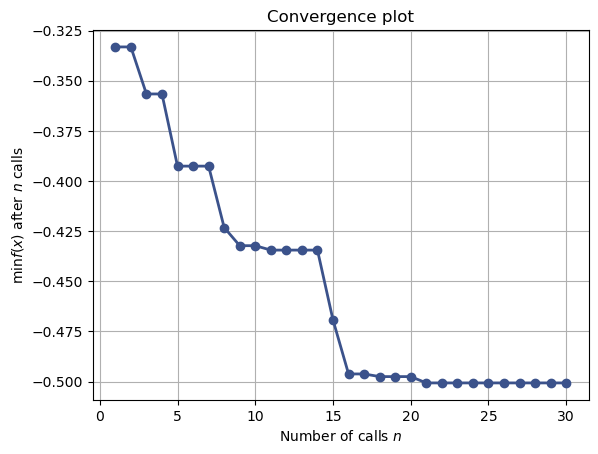

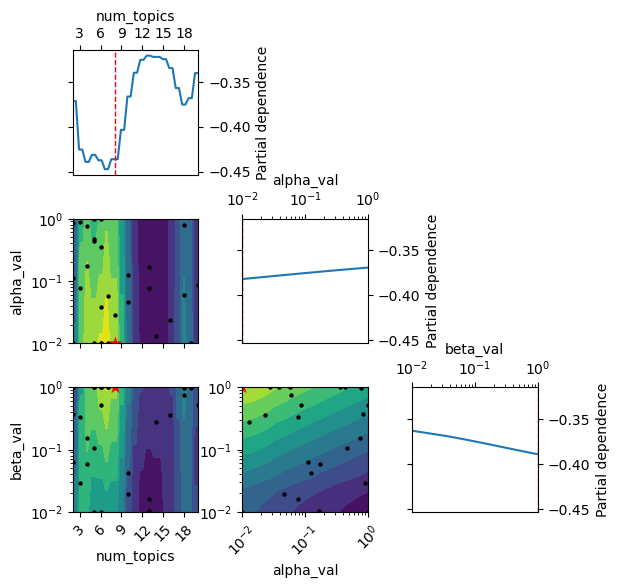

[codecarbon INFO @ 18:02:24] Energy consumed for RAM : 0.002600 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:02:24] Energy consumed for all CPUs : 0.036836 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:02:24] 0.039436 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:03:24] Energy consumed for RAM : 0.002650 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:03:24] Energy consumed for all CPUs : 0.037544 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:03:24] 0.040194 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:24] Energy consumed for RAM : 0.002700 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:04:24] Energy consumed for all CPUs : 0.038252 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:04:24] 0.040952 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:24] Energy consumed for RAM : 0.002750 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:05:24] Energy consumed for all CPUs : 0.038961 kWh. Total CPU Power : 42.5 W
[codeca

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective

# Define the search space
space = [
    Integer(2, 20, name='num_topics'),
    Real(0.01, 1.0, prior='log-uniform', name='alpha_val'),
    Real(0.01, 1.0, prior='log-uniform', name='beta_val'),
]

# Define the objective function
@use_named_args(space)
def objective(**params):
    # Extract parameters
    num_topics = params['num_topics']
    alpha = params['alpha_val']
    beta = params['beta_val']
    
    # Create and evaluate the model using LdaModel instead of LdaMulticore
    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,  # Match the baseline
        chunksize=500,     # Match the baseline
        passes=20,         # Match the baseline
        alpha=alpha,       
        eta=beta,         
        per_word_topics=True
    )

    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=docs, 
        dictionary=dictionary, 
        coherence='c_v'
    )
    
    # Return negative coherence (we want to maximize coherence)
    return -coherence_model.get_coherence()

# Run Bayesian optimization
result = gp_minimize(objective, space, n_calls=30, random_state=42, verbose=True)

best_alpha = result.x[1]
best_beta = result.x[2]
best_num_topics = result.x[0]
best_coherence = -result.fun

# Print best parameters
print(f"Best parameters: num_topics={result.x[0]}, alpha={result.x[1]}, beta={result.x[2]}")
print(f"Best coherence score: {-result.fun}")

# Visualize results
plot_convergence(result)
plot_objective(result)


## Step 5 - Run LDA model with best hyperparameters after finetuning

In [ ]:
# Define the best parameters
num_topics= best_num_topics
alpha=best_alpha
beta=best_beta

In [ ]:
print(f"num_topics: {num_topics}")
print(f"alpha: {alpha}")
print(f"beta: {beta}")

num_topics: 8
alpha: 0.01
beta: 1.0


[codecarbon INFO @ 18:57:24] Energy consumed for RAM : 0.005350 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:57:24] Energy consumed for all CPUs : 0.075799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:57:24] 0.081148 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:58:24] Energy consumed for RAM : 0.005400 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:58:24] Energy consumed for all CPUs : 0.076507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:58:24] 0.081907 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:59:24] Energy consumed for RAM : 0.005450 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:59:24] Energy consumed for all CPUs : 0.077215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:59:24] 0.082665 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:24] Energy consumed for RAM : 0.005500 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:00:24] Energy consumed for all CPUs : 0.077924 kWh. Total CPU Power : 42.5 W
[codeca

In [25]:
# setting the final model, except for the 3 hyperparameters, keeping the rest the same
lda_model_final = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=100,
                                       chunksize=500,
                                       passes=20,
                                       alpha=alpha,
                                       eta=beta,
                                       per_word_topics=True)


[codecarbon INFO @ 18:52:24] Energy consumed for RAM : 0.005100 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:52:24] Energy consumed for all CPUs : 0.072257 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:52:24] 0.077357 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:24] Energy consumed for RAM : 0.005150 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:53:24] Energy consumed for all CPUs : 0.072965 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:53:24] 0.078115 kWh of electricity used since the beginning.


In [ ]:
# save the final model
lda_model_final.save('lda_model_final.gensim')


Check with various Coherence scores for the assigned number of topics and hpyerparameters.

In [27]:
coherences = ['c_v', 'u_mass', 'c_uci', 'c_npmi']
for coherence in coherences:
    if coherence == 'u_mass':
        cm = CoherenceModel(model=lda_model_final, corpus=corpus, dictionary=dictionary, coherence=coherence)
    else:
        cm = CoherenceModel(model=lda_model_final, texts=docs, dictionary=dictionary, coherence=coherence)
    print(f'After finetuning, Coherence Score {coherence}: {cm.get_coherence()}\n')


After finetuning, Coherence Score c_v: 0.5006327320422286

After finetuning, Coherence Score u_mass: -3.7192592884569473

After finetuning, Coherence Score c_uci: 0.4056289808792113

After finetuning, Coherence Score c_npmi: 0.06692344004303835



In [28]:
# plot the topics
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)
#visualizing using Gensim
vis = pyLDAvis.gensim.prepare(lda_model_final, corpus, dictionary)
pyLDAvis.display(vis)

In [ ]:
# plot the top words in each topic
topics = lda_model_final.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.033*"model" + 0.027*"base" + 0.017*"datum" + 0.014*"analysis" + 0.014*"application" + 0.014*"-" + 0.012*"network" + 0.011*"system" + 0.011*"learning" + 0.009*"time"')
(1, '0.035*"care" + 0.031*"health" + 0.016*"student" + 0.016*"study" + 0.015*"experience" + 0.014*"impact" + 0.013*"healthcare" + 0.012*"practice" + 0.012*"medical" + 0.012*"mental"')
(2, '0.067*"review" + 0.030*"systematic" + 0.026*"cell" + 0.018*"analysis" + 0.016*"meta" + 0.012*"induce" + 0.011*"disease" + 0.010*"effect" + 0.010*"injury" + 0.009*"literature"')
(3, '0.051*"study" + 0.049*"-" + 0.020*"factor" + 0.018*"adult" + 0.018*"risk" + 0.017*"cross" + 0.014*"population" + 0.014*"sectional" + 0.013*"mortality" + 0.013*"non"')
(4, '0.022*"health" + 0.015*"social" + 0.013*"challenge" + 0.012*"research" + 0.012*"crisis" + 0.012*"impact" + 0.011*"global" + 0.010*"public" + 0.010*"policy" + 0.009*"perspective"')
(5, '0.062*"disease" + 0.039*"coronavirus" + 0.035*"infection" + 0.034*"clinical" + 0.033*"case" + 0.03

[codecarbon INFO @ 18:54:24] Energy consumed for RAM : 0.005200 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:54:24] Energy consumed for all CPUs : 0.073673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:54:24] 0.078873 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:24] Energy consumed for RAM : 0.005250 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:55:24] Energy consumed for all CPUs : 0.074382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:55:24] 0.079632 kWh of electricity used since the beginning.


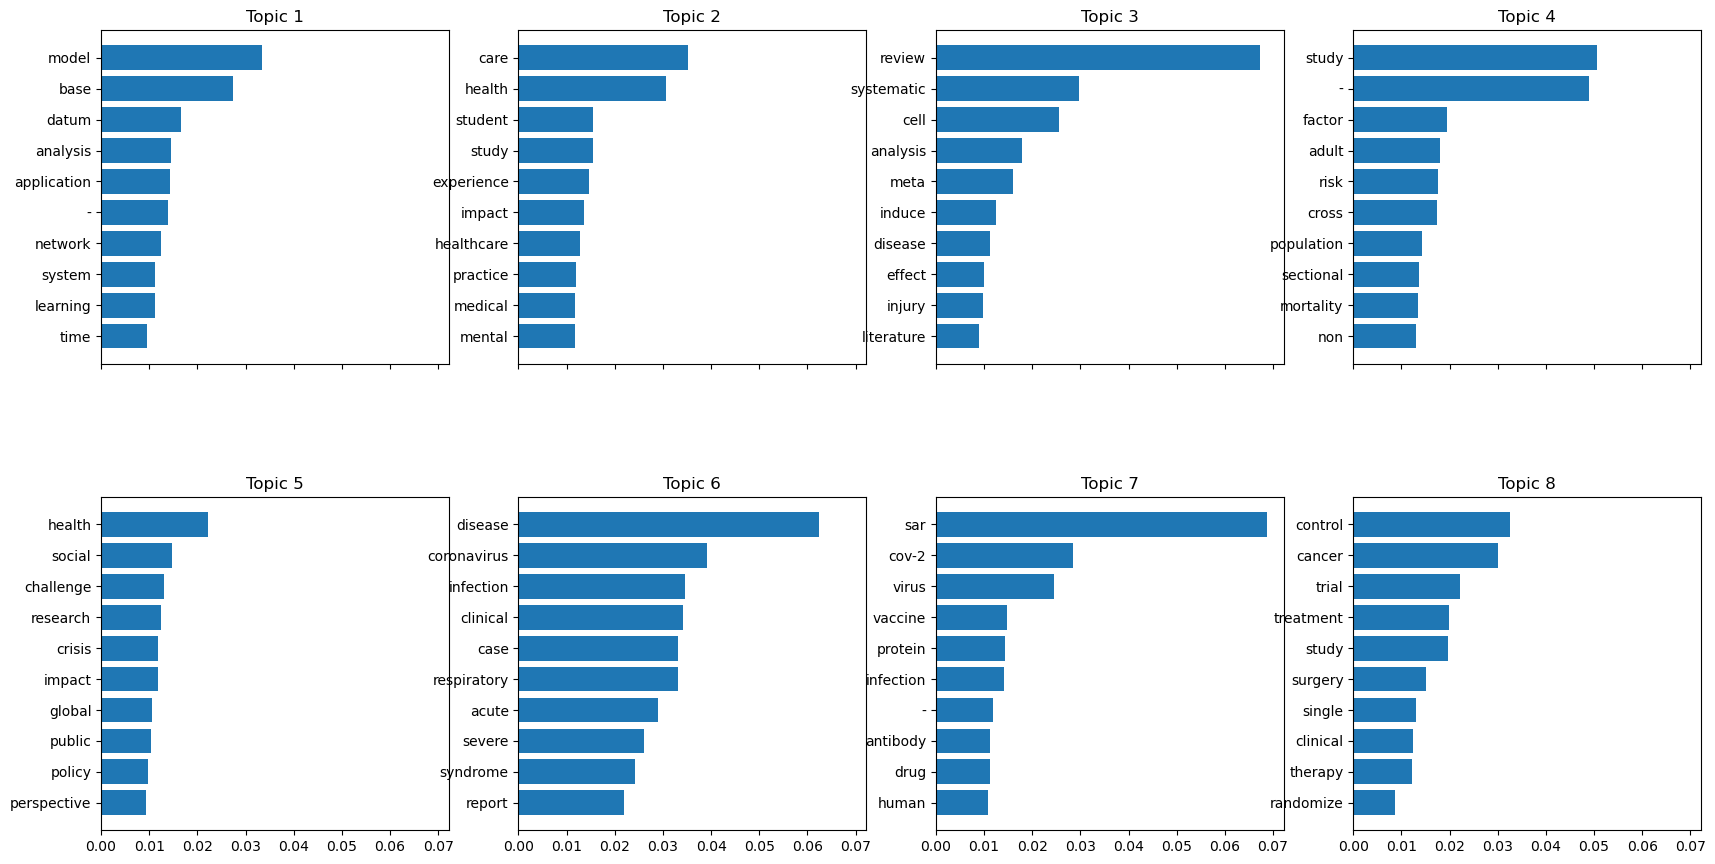

[codecarbon INFO @ 18:56:24] Energy consumed for RAM : 0.005300 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 18:56:24] Energy consumed for all CPUs : 0.075090 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:56:24] 0.080390 kWh of electricity used since the beginning.


In [30]:
# Plotting the top words in each topic
def plot_top_words_gensim(model, feature_names, n_top_words):
    # Dynamically calculate the grid size based on the number of topics
    n_rows = (num_topics + 3) // 4  # 4 topics per row
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.show_topics(formatted=False, num_topics=num_topics, num_words=n_top_words)):
        topic_words = topic[1]
        if topic_idx < len(axes):  # Ensure we don't access out-of-bounds axes
            ax = axes[topic_idx]
        # Extract top features (words) and their weights
        top_features = [word for word, weight in topic_words]
        weights = [weight for word, weight in topic_words]
        
        ax.barh(top_features, weights, align='center')
        ax.set_title(f'Topic {topic_idx + 1}')
        ax.invert_yaxis()
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4)
    plt.show()

# Get the feature names from the dictionary
feature_names = dictionary.values()
# Plot the top words in each topic
plot_top_words_gensim(lda_model_final, feature_names, n_top_words=10)

## Step 6 - Save the Results

In [ ]:
import json

# Create a more structured dictionary to store topic information
topic_data = {
    "model_info": {
        "num_topics": int(num_topics),
        "alpha": float(best_alpha),
        "beta": float(best_beta),
        "coherence_score_cv": float(best_coherence)
    },
    "topics": {}
}

# Extract the top words for each topic
for i in range(num_topics):
    topic_words = lda_model_final.show_topic(i, topn=10)  # Get top 10 words for each topic
    
    # Store as a list of word-weight pairs to preserve ranking
    topic_data["topics"][f"Topic_{i+1}"] = {
        "top_words": [{"word": word, "weight": float(weight)} for word, weight in topic_words]
    }

# Save to JSON file
with open('lda_title_topics.json', 'w') as f:
    json.dump(topic_data, f, indent=4)

print(f"Saved {num_topics} topics with model information to 'lda_title_topics.json'")

Saved 8 topics with model information to 'lda_title_topics.json'


In [ ]:
# stop the tracker
tracker.stop()

[codecarbon INFO @ 19:01:52] Energy consumed for RAM : 0.005573 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:01:52] Energy consumed for all CPUs : 0.078959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:01:52] 0.084532 kWh of electricity used since the beginning.
[codecarbon WARNING @ 19:01:52] graceful shutdown. Exceptions:
[codecarbon WARNING @ 19:01:52] <class 'Exception'>
Traceback (most recent call last):
  File "/Users/sophie/miniconda3/envs/test/lib/python3.9/site-packages/codecarbon/core/util.py", line 24, in suppress
    yield
  File "/Users/sophie/miniconda3/envs/test/lib/python3.9/contextlib.py", line 79, in inner
    return func(*args, **kwds)
  File "/Users/sophie/miniconda3/envs/test/lib/python3.9/site-packages/codecarbon/emissions_tracker.py", line 537, in stop
    emissions_data = self._prepare_emissions_data()
  File "/Users/sophie/miniconda3/envs/test/lib/python3.9/site-packages/codecarbon/emissions_tracker.py", line 573, in _prepare_emissions_data
    emissions 